# ML Challenge Problem 6 Part 3

UPDATE: Here I was trying to use an RNN to identify pulses. I did not get terribly far due mainly to the question on how to define the labels. I initially thought to insert single samples into the LSTM model and have it report the pulse sometime after seeing it pass. I went partway down the path and then learned about the TimeSeriesGenerator class in Keras so I backtracked and started playing with that. As I read and thought about it more, it seemed that the primary use of RNN's was to take a stream of information and predict the next element in that stream. The TimeSeriesGenerator allows one to define a model with multiple input samples (say 16) and have it "stride" through a larger list of samples (say 128). This seemed attractive due being able to fit an entire pulse into the inputs at once. Ultimately, this seemed very similar to a CNN and in fact, Kishan had recently suggested a Conv1D. I've decided to abandon the RNN idea for now and switch to a conv1D. This leaves the bottom of this notebook in a very broken state which is why I'm leaving this note to explain it.

<hr>

Here I try approaching the problem using an RNN. The idea here is to feed a continuous stream of samples through the RNN and have it recognize when a pulse has passed. The tricky part here is going to be how to generate the labels. It would not make much sense to specify the labels at the identified time of the pulse for a couple of reasons. One being that the samples past the pulse time should be used to help get the most accurate time. The other being that the identified pulse time is a floating point number somewhere in between samples.

The first thing to do here is to read all of the data into a dataframe.

In [3]:
# Read the full data file into a dataframe
# This file does not have a header so we define the column names here explicitly

import pandas as pd
import numpy as np

TRAIN_FILE  = '/home/davidl/work2/2020.08.12.ML_challenge6/Aug_2020_ML_train.csv'

# Columns in input file. First 5 are labels
names = ['ped', 'A1', 'A2', 't1', 't2']

# Next 128 are features (waveform)
for i in range(0,128): names.append('s%03d' % i)

# Read file and print how many waveforms are found
df = pd.read_csv(TRAIN_FILE, names=names)
print('Number of waveforms: %d' % len(df.index))

Number of waveforms: 1000


### Convert sample to time
Next, we need to figure out how to convert between sample number and the labeled times. What we really need is a way to convert a time into a sample number. This will allow us to know which samples are closest to the labeled times. This is needed so we can try training the RNN when to "emit" the time after a pulse has passed.

To do this, we'll take the minimum sample from the waveform (i.e. largest negative value representing the peak) and plot that vs. the labeled time, but only for single pulse waveforms. Do a linear regression on this to get the conversion values.

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ozl2o08l because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Fit Parameters: slope=0.985705  intercept=0.301877


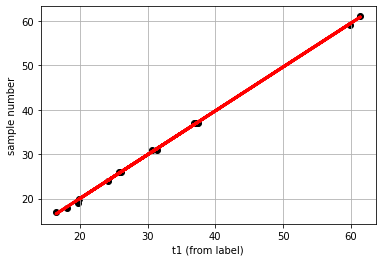

In [4]:
# There may be a cleaner way to do this, but it works. It gives a nice plot
# and one can use the regr.predict() method in later cells to convert the labels

from sklearn import linear_model
import matplotlib.pyplot as plt

# Add column to dataframe with sample number of peak and
# then slice dataframe to keep only single pulse waveforms
waveforms = df.to_numpy()                              # Convert all labels+waveforms to numpy arrays
waveforms = np.delete(waveforms, range(5), axis=1)     # Remove labels
locmax = np.argmin(waveforms, axis=1)                  # Find index of sample at peak
dflocmax = pd.DataFrame(locmax, columns=['maxsample']) # Create new dataframe with just one column containing peak location
df2 = pd.concat([df, dflocmax], axis=1)                # Create new dateframe with the new column added
dfA1_not_A2 = df2[(df2.A1>600.0) & (df2.A2==0)]        # Slice the dataframe to contain only waveforms with single, large pulses

# Do linear regression fit
N = len(dfA1_not_A2)
y = dfA1_not_A2['maxsample'].values.reshape(N,1)
x = dfA1_not_A2['t1'].values.reshape(N,1)
regr = linear_model.LinearRegression()
regr.fit(x, y)
m = regr.coef_
b = regr.intercept_

# Plot results
print('Fit Parameters: slope=%f  intercept=%f' % (m,b))
plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='red', linewidth=3)
plt.ylabel('sample number')
plt.xlabel('t1 (from label)')
plt.grid()
plt.show()

The above shows a y-intercept of significantly less than 1 sample and a slope very close to 1. It is probably safe to assume the units of time used for the labels are sample numbers where t=0.0 corresponds to the first sample.


## Prepare training set

Each set of features in the training set will be a list of 128 samples. In a final application, it would be nice to feed a continuous stream of samples to the model and have it "emit" a time/amplitude whenever it encounters a pulse. This makes the labels the tricky part. This first thing I'll try is making labels that specify how far back in time the pulse occured relative to the current sample. I'll make these labels such that 10 samples after the time given by the label from the CSV file are when the pulse should be emitted. This allows the network to accumulate data on the downward pulse.

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

avg_pulse_width = 12

# Add a dimension to waveforms since every sample will be an input feature
rnn_waveforms = waveforms.reshape((waveforms.shape[0],waveforms.shape[1],1))

# Create numpy array for labels, initialized to all zeros
rnn_labels = np.zeros(shape=(rnn_waveforms.shape[0],rnn_waveforms.shape[1],4))

generator = TimeseriesGenerator(rnn_waveforms, rnn_labels, length=avg_pulse_width, batch_size=1)
print('Samples: %d' % len(generator))
print('rnn_waveforms shape: %s  rnn_labels shape: %s' % (str(rnn_waveforms.shape), str(rnn_labels.shape)))        

for i in range(1):
    x, y = generator[i]
    print('shape x: %s   shape y: %s' % (str(x.shape), str(y.shape)))
    print('%s => %s' % (x, y))

Samples: 988
rnn_waveforms shape: (1000, 128, 1)  rnn_labels shape: (1000, 128, 4)
shape x: (1, 12, 128, 1)   shape y: (1, 128, 4)
[[[[ 0.]
   [ 5.]
   [ 0.]
   ...
   [-2.]
   [-1.]
   [12.]]

  [[ 0.]
   [-2.]
   [ 6.]
   ...
   [ 0.]
   [-4.]
   [ 4.]]

  [[-1.]
   [ 0.]
   [ 4.]
   ...
   [ 0.]
   [-1.]
   [ 6.]]

  ...

  [[ 0.]
   [-3.]
   [ 6.]
   ...
   [-2.]
   [ 0.]
   [ 4.]]

  [[ 4.]
   [-4.]
   [12.]
   ...
   [ 5.]
   [ 5.]
   [-4.]]

  [[ 0.]
   [ 1.]
   [-1.]
   ...
   [ 2.]
   [ 9.]
   [-1.]]]] => [[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]


In [5]:
# Make labels for each time step of each waveform
# Format will be:
#
#   [[sample0], [sample1], [sample2], ...]    features
#   [[ped,A,t], [ped,A,t], [ped,A,t], ...]    labels
import math

emit_sample_offset = 8  # Number of samples after true time to wait before emitting sample

# Add a dimension to waveforms since every sample will be an input feature
rnn_waveforms = waveforms.reshape((waveforms.shape[0],waveforms.shape[1],1))

# Create numpy array for labels, initialized to all zeros
rnn_labels = np.zeros(shape=(rnn_waveforms.shape[0],rnn_waveforms.shape[1],4))

# Create numpy array of just labels from CSV file
labels = df.to_numpy()                                        # Convert all labels+waveforms to numpy arrays
labels = np.delete(labels, range(5,labels.shape[1]), axis=1)  # Remove samples

# Loop over waveforms, updating rnn_labels for those samples where we want pulse parameters emitted
for i in range(len(rnn_waveforms)):
    # t1
    if labels[i,3]>=0 :
        isample = int(math.floor(labels[i,3]) + emit_sample_offset)
        delta_t = float(isample) - labels[i,3]
        rnn_labels[i,isample] = [1, labels[i,0], labels[i,1], delta_t]  # ([ped, A1, t1])
    # t2
    if labels[i,4]>=0 :
        isample = int(math.floor(labels[i,4]) + emit_sample_offset)
        delta_t = float(isample) - labels[i,4]
        rnn_labels[i,isample] = [1, labels[i,0], labels[i,2], delta_t]  # ([ped, A2, t2])

print('rnn_waveforms shape: %s  rnn_labels shape: %s' % (str(rnn_waveforms.shape), str(rnn_labels.shape)))        

rnn_waveforms shape: (190071, 128, 1)  rnn_labels shape: (190071, 128, 4)


## Define Model

In [6]:
import tensorflow as tf
import tensorflow.keras as keras

from keras.models import Model, Sequential
from keras.layers import Dense, TimeDistributed, Input, Lambda, LSTM

# Model will have single input: the sample amplitude
# It will have two outputs: time and amplitude of pulse
def DefineModel():
    model = Sequential()
    model.add( LSTM(units=32, return_sequences=True, input_shape=(None,1)) )  #  None -> undefined number of time steps
    model.add( LSTM(units=32, return_sequences=True) )
    model.add( LSTM(units=32, return_sequences=True) )
    model.add( TimeDistributed(Dense(units=4)) )
    return model

def CustomLoss(y_true, y_pred):
    print('y_pred shape: %s   y_true shape: %s' % (str(y_pred), str(y_true)))
    

model = DefineModel()
model.compile(optimizer='adam', loss=CustomLoss, metrics=['mse', 'mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 4)           132       
Total params: 21,124
Trainable params: 21,124
Non-trainable params: 0
_________________________________________________________________


In [7]:
print('rnn_waveforms shape: %s  rnn_labels shape: %s' % (str(rnn_waveforms.shape), str(rnn_labels.shape)))        

BATCH_SIZE=32
EPOCHS=1

history = model.fit(
    x=rnn_waveforms,
    y=rnn_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

rnn_waveforms shape: (190071, 128, 1)  rnn_labels shape: (190071, 128, 4)
y_pred shape: Tensor("sequential/time_distributed/Reshape_1:0", shape=(None, 128, 4), dtype=float32)   y_true shape: Tensor("IteratorGetNext:1", shape=(None, 128, 4), dtype=float32)


ValueError: in user code:

    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:151 __call__
        losses, sample_weight, reduction=self._get_reduction())
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/keras/utils/losses_utils.py:106 compute_weighted_loss
        losses = ops.convert_to_tensor_v2(losses)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1382 convert_to_tensor_v2
        as_ref=False)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1499 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:338 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:264 constant
        allow_broadcast=True)
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:282 _constant_impl
        allow_broadcast=allow_broadcast))
    /w/halld-scifs17exp/halld2/home/davidl/builds/Python_VENV/venv_2020.10.13.tf2.3.1/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:444 make_tensor_proto
        raise ValueError("None values not supported.")

    ValueError: None values not supported.


In [10]:
# save the model
import time 
model_save_dir = time.strftime('%Y.%m.%d-%H:%M')
print('model_save_dir="%s"' % model_save_dir)
model.save('RNN_models/'+model_save_dir)

model_save_dir="2020.10.25-12:42"
INFO:tensorflow:Assets written to: RNN_models/2020.10.25-12:42/assets


## Test the model

Here we test the model by giving it a wavform and seeing the response

In [20]:
def TestWaveform(mydf, irow):
    row = mydf.iloc[irow].tolist()
    
    waveform = np.reshape(row[5:],(1,128,1))
    label    = row[:5]
    
    model.reset_states()
    y_pred = model.predict(waveform)
    print(label)
    print(y_pred)

TestWaveform(df, 0)

[2.13243, 263.75, 0.0, 38.0609, -1.0]
[[[-2.43019909e-02  3.00599813e-01 -2.49379687e-02]
  [-1.15752909e-02 -1.36694193e-01  2.88562197e-03]
  [-2.79591791e-03 -1.36397123e-01  3.94996107e-02]
  [-5.75227290e-03  1.92675591e-01  6.82029650e-02]
  [-8.53197090e-03  2.17434406e-01  6.11457229e-02]
  [-1.00968182e-02  1.34024620e-01  4.80487123e-02]
  [-9.85159539e-03  6.03497028e-02  1.84858702e-02]
  [-7.88105279e-03 -8.53276253e-03 -3.38472752e-03]
  [-3.77660803e-03 -1.94060802e-02 -1.56790689e-02]
  [ 1.02602132e-03 -1.66916847e-03 -1.23903928e-02]
  [ 5.06734475e-04 -2.51238346e-02 -3.40071972e-03]
  [-3.86456028e-04  1.09283924e-02  1.81947183e-03]
  [-1.51976012e-03  2.52463818e-02  3.36585008e-03]
  [-2.94969976e-03  3.71434689e-02  4.04399540e-03]
  [-3.14571336e-03  2.02960968e-02  1.03704445e-03]
  [-4.83752042e-03  3.83076668e-02  2.13318411e-03]
  [-3.81806493e-03 -2.88009644e-03 -4.91969381e-03]
  [-4.07870673e-03  2.24642754e-02 -6.26969337e-03]
  [-2.55214982e-03 -2.8304

In [ ]:
from IPython.display import Image, HTML, display
import png
import os

# Generate one PNG image file for the specified entry and dataframe.
# The drawlines option can set whether to draw lines between points.
# The prefix value will be prepended on the outpout filenames.
def MakeImage(irow, drawlines=False, mydf=df, prefix='', dirname='.'):
    row = mydf.iloc[irow][5:].tolist()
    
    width  = 128
    height = 512+100
    img = []
    for y in range(height):
        r = [255]*width
        img.append(r)

    for icol in range(width):
        yval = (100-int(row[icol]))  # For positive pulses: height - (100-int(row[icol]))
        yval = min(height-1, max(0, yval))
        img[yval][icol] = 0
        
        # Optionally draw lines between the dots
        if drawlines:
            if icol>0 :
                ymid = (int)((yval + last_yval)/2)
                ylo = min(last_yval, ymid)
                yhi = max(last_yval, ymid)
                for ylin in range(ylo, yhi): img[ylin][icol-1] = 0
                ylo = min(ymid, yval)
                yhi = max(ymid, yval)
                for ylin in range(ylo, yhi): img[ylin][icol-1] = 0
            last_yval = yval
    fname = prefix+'waveform_%06d.png' % irow
    if dirname != '.':
        try:
            os.makedirs(dirname)
        except:
            pass  # assume excpetion is because it already exists
        fname = os.path.join(dirname, fname)
    with open(fname, 'wb') as f:    
        w = png.Writer(width, height, greyscale=True)
        w.write(f, img)
        #print('Wrote file: ' + fname)
    return fname